In [1]:
!pip install captum
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
!pip uninstall -y numpy
!pip install numpy==1.25.2
!pip install torchvision

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 96.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, resnet34
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
import random
from PIL import Image
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import time
from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import GuidedGradCam, LayerGradCam, IntegratedGradients
import torch.nn.functional as F
from google.colab import files
import zipfile
import shutil
from google.colab.patches import cv2_imshow

In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip -q 140k-real-and-fake-faces.zip -d deepfake_dataset

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other


In [3]:
base_path = '//content/deepfake_dataset'
for folder in os.listdir(base_path):
    full_path = os.path.join(base_path, folder)
    if os.path.isdir(full_path):
        print(folder, "→", len(os.listdir(full_path)), "items")

def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

base_path = '/content/deepfake_dataset/real_vs_fake/real-vs-fake'
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_path, split)
    for category in ['real', 'fake']:
        cat_path = os.path.join(split_path, category)
        if os.path.isdir(cat_path):
            print(f"{split}/{category} → {count_images(cat_path)} images")

real_vs_fake → 1 items
train/real → 50000 images
train/fake → 50000 images
valid/real → 10000 images
valid/fake → 10000 images
test/real → 10000 images
test/fake → 10000 images


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Train dataset size: 40000
Validation dataset size: 8000
Test dataset size: 8000
Total dataset size: 56000


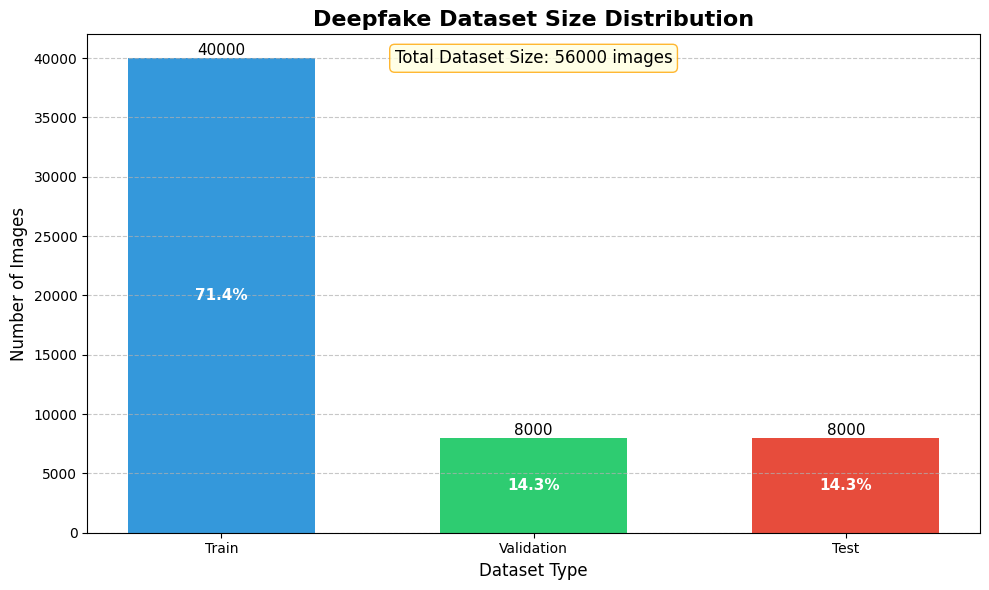

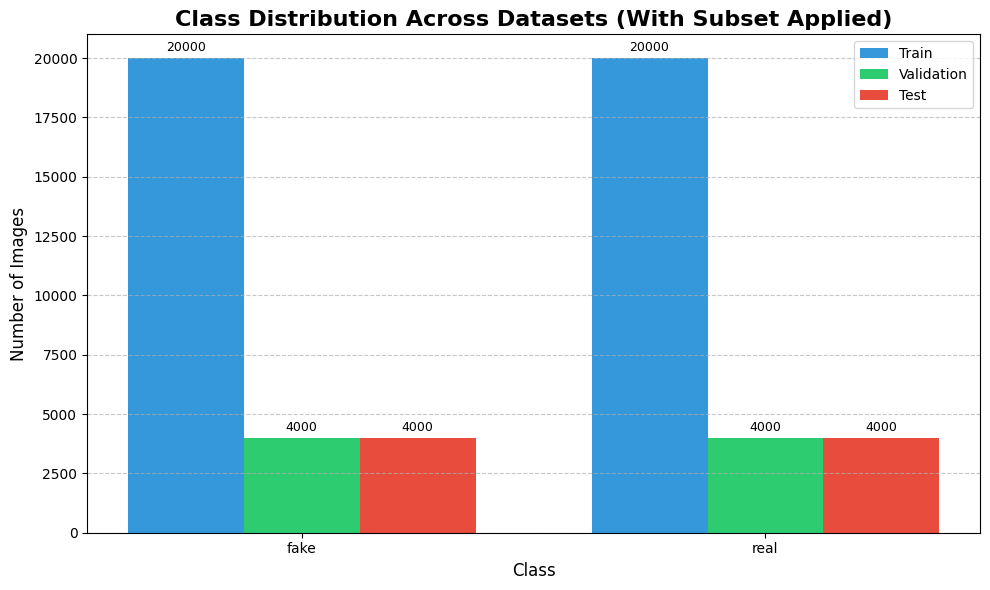

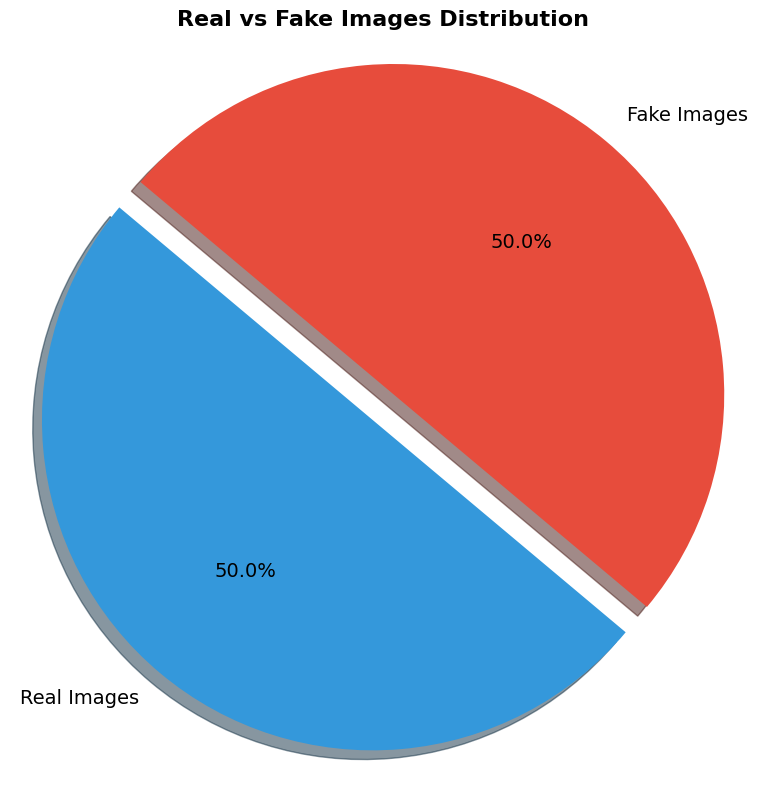

In [20]:
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None, subset_fraction=None):
        self.dataset = ImageFolder(root_dir, transform=transform)
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx

        if subset_fraction is not None and subset_fraction < 1.0:
            num_samples = int(len(self.dataset) * subset_fraction)
            indices = torch.randperm(len(self.dataset))[:num_samples]
            self.dataset = Subset(self.dataset, indices)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

base_dir = '/content/deepfake_dataset/real_vs_fake/real-vs-fake'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

subset_fraction = 0.4
train_dataset = DeepfakeDataset(train_dir, transform=data_transforms['train'], subset_fraction=subset_fraction)
valid_dataset = DeepfakeDataset(valid_dir, transform=data_transforms['val_test'], subset_fraction=subset_fraction)
test_dataset = DeepfakeDataset(test_dir, transform=data_transforms['val_test'], subset_fraction=subset_fraction)

train_size = len(train_dataset)
valid_size = len(valid_dataset)
test_size = len(test_dataset)
total_size = train_size + valid_size + test_size

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {valid_size}")
print(f"Test dataset size: {test_size}")
print(f"Total dataset size: {total_size}")

train_percent = (train_size / total_size) * 100
valid_percent = (valid_size / total_size) * 100
test_percent = (test_size / total_size) * 100

plt.figure(figsize=(10, 6))

dataset_types = ['Train', 'Validation', 'Test']
dataset_sizes = [train_size, valid_size, test_size]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = plt.bar(dataset_types, dataset_sizes, color=colors, width=0.6)

plt.title('Deepfake Dataset Size Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Dataset Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=11)

for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = [train_percent, valid_percent, test_percent][i]
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{percentage:.1f}%', ha='center', va='center',
             fontsize=11, fontweight='bold', color='white')

plt.annotate(f'Total Dataset Size: {total_size} images',
             xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', va='top', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.8))

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

def count_classes(dataset_dir):
    """Count images per class in the given directory"""
    full_dataset = ImageFolder(dataset_dir)
    classes = full_dataset.classes
    class_counts = {cls: 0 for cls in classes}

    for _, class_idx in full_dataset.samples:
        class_name = classes[class_idx]
        class_counts[class_name] += 1

    return class_counts, classes

train_class_counts, classes = count_classes(train_dir)
valid_class_counts, _ = count_classes(valid_dir)
test_class_counts, _ = count_classes(test_dir)

for cls in train_class_counts:
    train_class_counts[cls] = int(train_class_counts[cls] * subset_fraction)
    valid_class_counts[cls] = int(valid_class_counts[cls] * subset_fraction)
    test_class_counts[cls] = int(test_class_counts[cls] * subset_fraction)

class_names = list(train_class_counts.keys())
train_counts = [train_class_counts[cls] for cls in class_names]
valid_counts = [valid_class_counts[cls] for cls in class_names]
test_counts = [test_class_counts[cls] for cls in class_names]

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train', color='#3498db')
rects2 = ax.bar(x, valid_counts, width, label='Validation', color='#2ecc71')
rects3 = ax.bar(x + width, test_counts, width, label='Test', color='#e74c3c')

ax.set_ylabel('Number of Images', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_title('Class Distribution Across Datasets (With Subset Applied)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

real_total = sum(train_class_counts.get('real', 0) + valid_class_counts.get('real', 0) + test_class_counts.get('real', 0)
                for cls in class_names if 'real' in cls.lower())
fake_total = sum(train_class_counts.get('fake', 0) + valid_class_counts.get('fake', 0) + test_class_counts.get('fake', 0)
                for cls in class_names if 'fake' in cls.lower())

plt.figure(figsize=(8, 8))
labels = ['Real Images', 'Fake Images']
sizes = [real_total, fake_total]
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 14})
plt.axis('equal')
plt.title('Real vs Fake Images Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('real_vs_fake_pie.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

class DeepfakeDetector(nn.Module):
    def __init__(self, model_name='resnet34', pretrained=True):
        super(DeepfakeDetector, self).__init__()

        self.model_name = model_name

        if model_name == 'efficientnet_b0':
            self.base_model = efficientnet_b0(pretrained=pretrained)
            num_ftrs = self.base_model.classifier[1].in_features
            self.base_model.classifier = nn.Identity()

            self.classifier = nn.Sequential(
                nn.Dropout(0.4),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.3),
                nn.Linear(256, 2)
            )

        elif model_name == 'resnet34':
            self.base_model = resnet34(pretrained=pretrained)
            num_ftrs = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()

            self.classifier = nn.Sequential(
                nn.Dropout(0.4),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.3),
                nn.Linear(256, 2)
            )

        if model_name == 'efficientnet_b0':
            self.target_layer = self.base_model.features[-1]
        elif model_name == 'resnet34':
            self.target_layer = self.base_model.layer4[-1]

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

    def get_target_layer(self):
        return self.target_layer

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss, model, path):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), path)
            self.counter = 0
            if self.verbose:
                print(f"Model saved with validation loss: {val_loss:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Early stop counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered!")

In [10]:
model_name = 'resnet34'
model = DeepfakeDetector(model_name=model_name, pretrained=True).to(device)
print(f"Initialized {model_name} model")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, model_path):

    early_stopping = EarlyStopping(patience=5, verbose=True)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(valid_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(valid_loader.dataset)

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")
        print(f"Epoch completed in {(time.time() - start_time)/60:.2f} minutes")

        if scheduler:
            scheduler.step(val_epoch_loss)

        early_stopping(val_epoch_loss, model, model_path)
        if early_stopping.early_stop:
            print("Training stopped early!")
            break

    model.load_state_dict(torch.load(model_path))

    return model, history

num_epochs = 15

model_path = f'deepfake_detector_{model_name}.pth'

trained_model, history = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, model_path
)

print(f"Model training completed and saved to {model_path}")

Initialized resnet34 model

Epoch 1/15


Training: 100%|██████████| 1250/1250 [05:35<00:00,  3.72it/s]


Train Loss: 0.4238, Accuracy: 0.8578


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.03it/s]


Validation Loss: 0.2845, Accuracy: 0.9509
Epoch completed in 6.02 minutes
Model saved with validation loss: 0.2845

Epoch 2/15


Training: 100%|██████████| 1250/1250 [05:20<00:00,  3.90it/s]


Train Loss: 0.3061, Accuracy: 0.9403


Validation: 100%|██████████| 250/250 [00:25<00:00,  9.75it/s]


Validation Loss: 0.2461, Accuracy: 0.9720
Epoch completed in 5.77 minutes
Model saved with validation loss: 0.2461

Epoch 3/15


Training: 100%|██████████| 1250/1250 [05:16<00:00,  3.95it/s]


Train Loss: 0.2742, Accuracy: 0.9594


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.23it/s]


Validation Loss: 0.2273, Accuracy: 0.9833
Epoch completed in 5.69 minutes
Model saved with validation loss: 0.2273

Epoch 4/15


Training: 100%|██████████| 1250/1250 [05:16<00:00,  3.95it/s]


Train Loss: 0.2586, Accuracy: 0.9688


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.30it/s]


Validation Loss: 0.2321, Accuracy: 0.9815
Epoch completed in 5.68 minutes
No improvement. Early stop counter: 1/5

Epoch 5/15


Training: 100%|██████████| 1250/1250 [05:14<00:00,  3.98it/s]


Train Loss: 0.2508, Accuracy: 0.9741


Validation: 100%|██████████| 250/250 [00:25<00:00,  9.73it/s]


Validation Loss: 0.2249, Accuracy: 0.9844
Epoch completed in 5.66 minutes
Model saved with validation loss: 0.2249

Epoch 6/15


Training: 100%|██████████| 1250/1250 [05:16<00:00,  3.95it/s]


Train Loss: 0.2474, Accuracy: 0.9755


Validation: 100%|██████████| 250/250 [00:23<00:00, 10.47it/s]


Validation Loss: 0.2236, Accuracy: 0.9864
Epoch completed in 5.67 minutes
Model saved with validation loss: 0.2236

Epoch 7/15


Training: 100%|██████████| 1250/1250 [05:19<00:00,  3.92it/s]


Train Loss: 0.2399, Accuracy: 0.9808


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.23it/s]


Validation Loss: 0.2198, Accuracy: 0.9874
Epoch completed in 5.73 minutes
Model saved with validation loss: 0.2198

Epoch 8/15


Training: 100%|██████████| 1250/1250 [05:18<00:00,  3.92it/s]


Train Loss: 0.2376, Accuracy: 0.9817


Validation: 100%|██████████| 250/250 [00:23<00:00, 10.48it/s]


Validation Loss: 0.2222, Accuracy: 0.9863
Epoch completed in 5.71 minutes
No improvement. Early stop counter: 1/5

Epoch 9/15


Training: 100%|██████████| 1250/1250 [05:15<00:00,  3.96it/s]


Train Loss: 0.2359, Accuracy: 0.9822


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.42it/s]


Validation Loss: 0.2153, Accuracy: 0.9899
Epoch completed in 5.66 minutes
Model saved with validation loss: 0.2153

Epoch 10/15


Training: 100%|██████████| 1250/1250 [05:13<00:00,  3.99it/s]


Train Loss: 0.2340, Accuracy: 0.9840


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.30it/s]


Validation Loss: 0.2199, Accuracy: 0.9874
Epoch completed in 5.63 minutes
No improvement. Early stop counter: 1/5

Epoch 11/15


Training: 100%|██████████| 1250/1250 [05:12<00:00,  4.00it/s]


Train Loss: 0.2309, Accuracy: 0.9853


Validation: 100%|██████████| 250/250 [00:25<00:00,  9.88it/s]


Validation Loss: 0.2179, Accuracy: 0.9881
Epoch completed in 5.63 minutes
No improvement. Early stop counter: 2/5

Epoch 12/15


Training: 100%|██████████| 1250/1250 [05:11<00:00,  4.02it/s]


Train Loss: 0.2285, Accuracy: 0.9873


Validation: 100%|██████████| 250/250 [00:24<00:00, 10.24it/s]


Validation Loss: 0.2140, Accuracy: 0.9920
Epoch completed in 5.59 minutes
Model saved with validation loss: 0.2140

Epoch 13/15


Training: 100%|██████████| 1250/1250 [05:12<00:00,  4.01it/s]


Train Loss: 0.2271, Accuracy: 0.9880


Validation: 100%|██████████| 250/250 [00:23<00:00, 10.59it/s]


Validation Loss: 0.2155, Accuracy: 0.9905
Epoch completed in 5.59 minutes
No improvement. Early stop counter: 1/5

Epoch 14/15


Training: 100%|██████████| 1250/1250 [05:11<00:00,  4.01it/s]


Train Loss: 0.2255, Accuracy: 0.9888


Validation: 100%|██████████| 250/250 [00:23<00:00, 10.54it/s]


Validation Loss: 0.2156, Accuracy: 0.9900
Epoch completed in 5.60 minutes
No improvement. Early stop counter: 2/5

Epoch 15/15


Training: 100%|██████████| 1250/1250 [05:11<00:00,  4.01it/s]


Train Loss: 0.2265, Accuracy: 0.9883


Validation: 100%|██████████| 250/250 [00:23<00:00, 10.80it/s]


Validation Loss: 0.2117, Accuracy: 0.9926
Epoch completed in 5.58 minutes
Model saved with validation loss: 0.2117
Model training completed and saved to deepfake_detector_resnet34.pth


In [11]:
from google.colab import files
files.download('/content/deepfake_detector_resnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

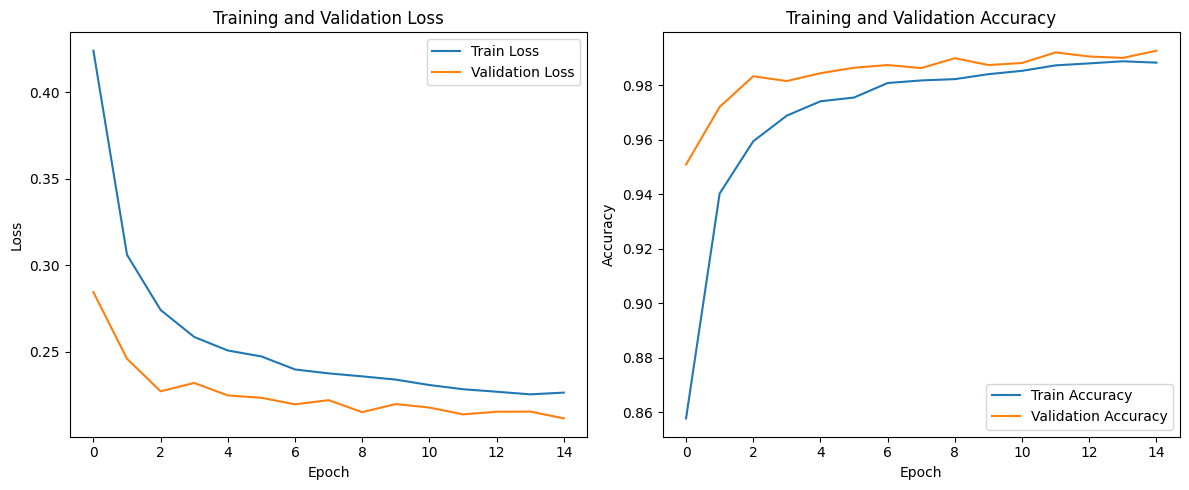

Testing: 100%|██████████| 250/250 [00:29<00:00,  8.35it/s]



 Test Accuracy: 0.9921

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4023
        Fake       0.99      0.99      0.99      3977

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



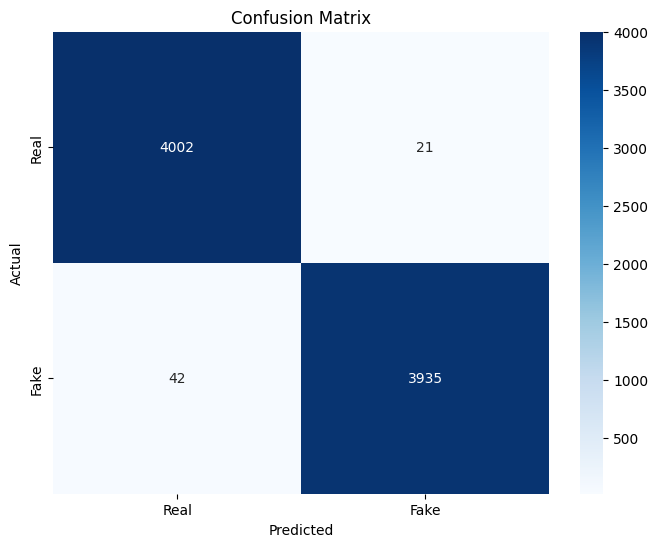

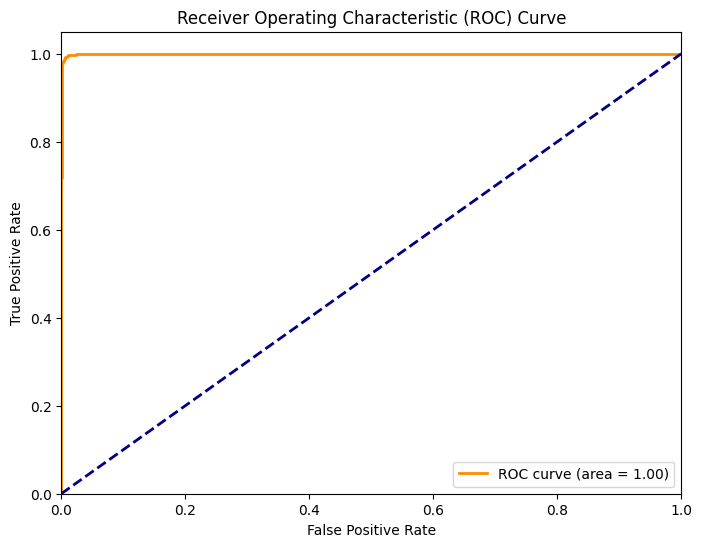


Model saved to: deepfake_detector_resnet34_final.pth
Model and results archived in: deepfake_detector_resnet34_final.zip


In [12]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n Test Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

    return accuracy, cm, roc_auc

test_acc, conf_matrix, roc_auc = evaluate_model(model, test_loader)

model_info = {
    'model_name': model_name,
    'accuracy': test_acc,
    'roc_auc': roc_auc,
    'state_dict': model.state_dict()
}

torch.save(model_info, f'deepfake_detector_{model_name}_final.pth')
print(f"\nModel saved to: deepfake_detector_{model_name}_final.pth")

with zipfile.ZipFile(f'deepfake_detector_{model_name}_final.zip', 'w') as zipf:
    zipf.write(f'deepfake_detector_{model_name}_final.pth')
    zipf.write('confusion_matrix.png')
    zipf.write('roc_curve.png')
    zipf.write('training_history.png')

print(f"Model and results archived in: deepfake_detector_{model_name}_final.zip")

In [13]:
def apply_gradcam(model, image_tensor, original_image):
    model.eval()

    target_layer = model.get_target_layer()

    grad_cam = LayerGradCam(model, target_layer)

    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()

    attribution = grad_cam.attribute(image_tensor, target=pred_class)
    attribution = attribution.cpu().detach().numpy().squeeze()
    attribution = cv2.resize(attribution, (224, 224))
    attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * attribution), cv2.COLORMAP_JET)

    original_np = np.array(original_image.resize((224, 224)))
    original_np = original_np[:, :, ::-1]

    superimposed_img = heatmap * 0.4 + original_np * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    superimposed_img = superimposed_img[:, :, ::-1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(original_image.resize((224, 224)))
    axes[0].set_title(f"Original Image - Predicted: {'Fake' if pred_class == 1 else 'Real'}")
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('GradCAM Visualization')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_result.png')
    plt.show()

    return pred_class, superimposed_img

In [14]:
def apply_lime(model, image_tensor, original_image):
    model.eval()

    def get_preds(images):
        batch = torch.stack([transforms.ToTensor()(img) for img in images])
        batch = batch.to(device)

        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        batch = (batch - mean) / std

        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    explainer = lime_image.LimeImageExplainer()

    image_np = np.array(original_image.resize((224, 224)))

    explanation = explainer.explain_instance(
        image_np,
        get_preds,
        top_labels=2,
        hide_color=0,
        num_samples=500
    )
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()

    temp, mask = explanation.get_image_and_mask(
        pred_class,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    lime_img = mark_boundaries(temp / 255.0, mask)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(original_image.resize((224, 224)))
    axes[0].set_title(f"Original Image - Predicted: {'Fake' if pred_class == 1 else 'Real'}")
    axes[0].axis('off')

    axes[1].imshow(lime_img)
    axes[1].set_title('LIME Explanation')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('lime_result.png')
    plt.show()

    return pred_class, lime_img

In [15]:
def prepare_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = data_transforms['val_test']
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

def predict_with_xai(model, image_path, xai_method='both'):
    original_image, image_tensor = prepare_image(image_path)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    pred_class = preds.item()
    prob_fake = probs[0][1].item()

    print(f"Prediction: {'Fake' if pred_class == 1 else 'Real'}")
    print(f"Probability of being fake: {prob_fake:.4f}")

    if xai_method == 'gradcam':
        print("\nGradCAM Visualization:")
        _, _ = apply_gradcam(model, image_tensor, original_image)
    elif xai_method == 'lime':
        print("\nLIME Visualization:")
        _, _ = apply_lime(model, image_tensor, original_image)
    elif xai_method == 'both':
        print("\nGradCAM Visualization:")
        _, _ = apply_gradcam(model, image_tensor, original_image)
        print("\nLIME Visualization:")
        _, _ = apply_lime(model, image_tensor, original_image)
    elif xai_method == 'ig':
        print("\nIntegrated Gradients Visualization:")
        _, _ = apply_integrated_gradients(model, image_tensor, original_image)

    return pred_class, prob_fake

In [16]:
def apply_integrated_gradients(model, image_tensor, original_image):
    model.eval()

    ig = IntegratedGradients(model)

    outputs = model(image_tensor)
    pred_prob = torch.nn.functional.softmax(outputs, dim=1)
    pred_class = torch.argmax(pred_prob, dim=1).item()

    class_name = "Fake" if pred_class == 1 else "Real"
    confidence = pred_prob[0][pred_class].item() * 100

    print(f"Prediction: {class_name} with {confidence:.2f}% confidence")

    attributions = ig.attribute(image_tensor, target=pred_class, n_steps=50)
    attribution = attributions.detach().cpu().numpy().squeeze()

    if len(attribution.shape) == 3:
        attribution = np.sum(np.abs(attribution), axis=0)

    if np.max(attribution) - np.min(attribution) != 0:
        attribution = (attribution - np.min(attribution)) / (np.max(attribution) - np.min(attribution))
    else:
        attribution = np.zeros_like(attribution)

    attribution_uint8 = np.uint8(255 * attribution)

    if len(attribution_uint8.shape) != 2:
        attribution_uint8 = cv2.cvtColor(attribution_uint8, cv2.COLOR_RGB2GRAY)

    heatmap = cv2.applyColorMap(attribution_uint8, cv2.COLORMAP_JET)

    if isinstance(original_image, Image.Image):
        original_np = np.array(original_image.resize((224, 224)))
    else:
        original_np = np.array(original_image)

    if heatmap.shape[:2] != original_np.shape[:2]:
        heatmap = cv2.resize(heatmap, (original_np.shape[1], original_np.shape[0]))

    if len(original_np.shape) == 3 and original_np.shape[2] == 3:
        original_np = cv2.cvtColor(original_np, cv2.COLOR_RGB2BGR)

    superimposed = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_np, cv2.COLOR_BGR2RGB))
    plt.title(f"Original - {class_name} ({confidence:.2f}%)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
    plt.title("Attribution Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title("Superimposed")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return pred_class, confidence

Selecting 5 random test samples (3 fake and 2 real) for prediction...

Predicting image /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/fake/D3KLVBH0TE.jpg - Label: Real

GradCAM Visualization:
Prediction: Real
Probability of being fake: 0.0514

GradCAM Visualization:


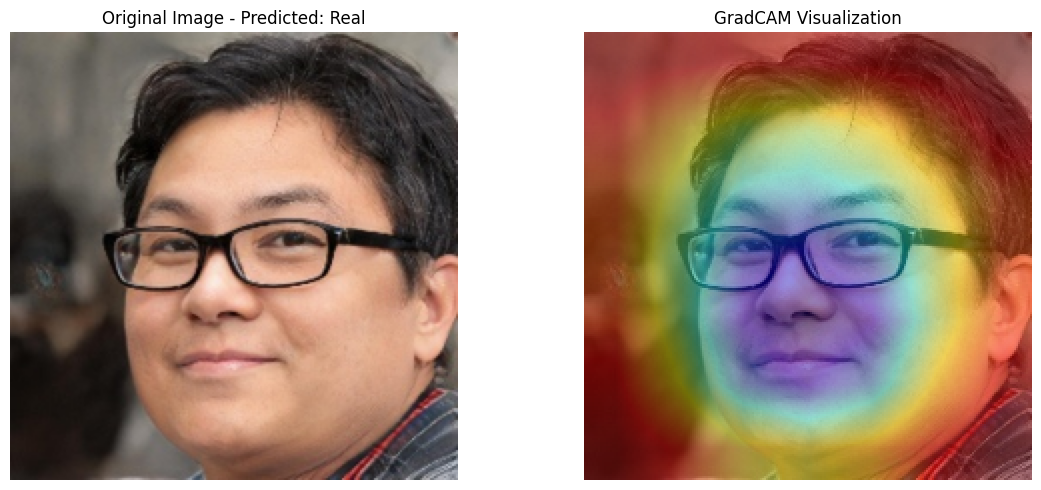


LIME Visualization:
Prediction: Real
Probability of being fake: 0.0514

LIME Visualization:


  0%|          | 0/500 [00:00<?, ?it/s]

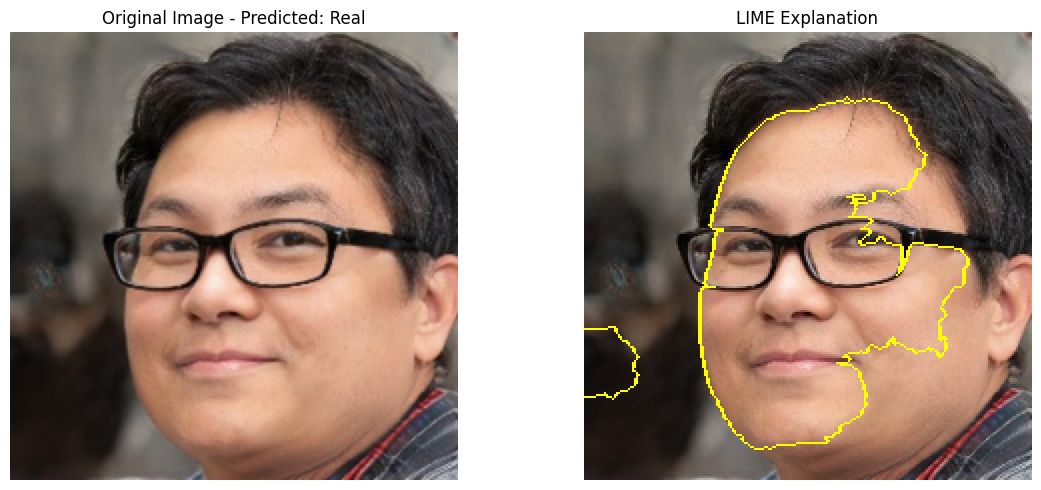


Integrated Gradients (IG) Visualization:
Prediction: Real with 94.86% confidence


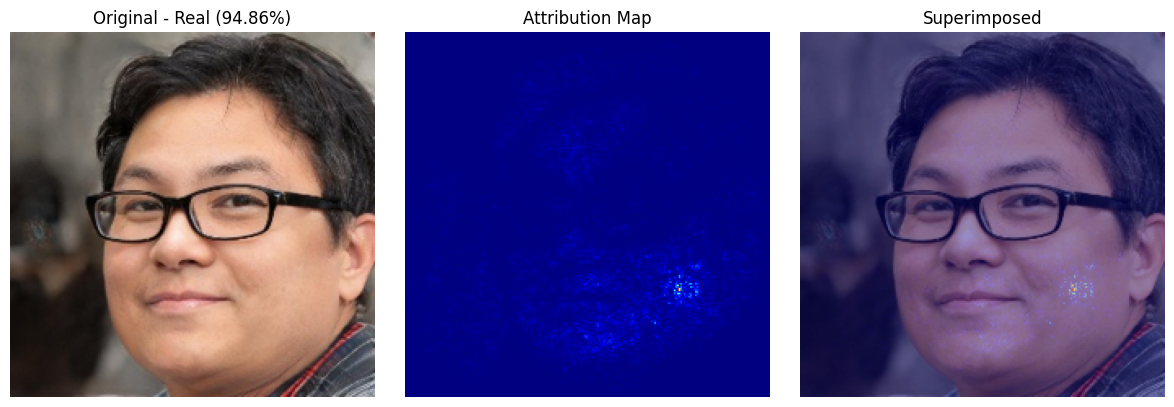


Predicting image /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/fake/EGG1XOIIZQ.jpg - Label: Real

GradCAM Visualization:
Prediction: Real
Probability of being fake: 0.0550

GradCAM Visualization:


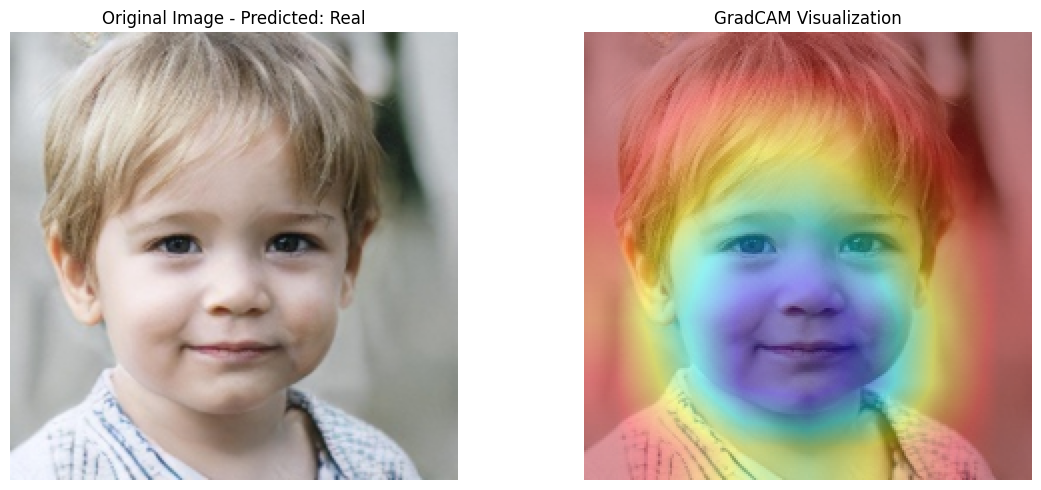


LIME Visualization:
Prediction: Real
Probability of being fake: 0.0550

LIME Visualization:


  0%|          | 0/500 [00:00<?, ?it/s]

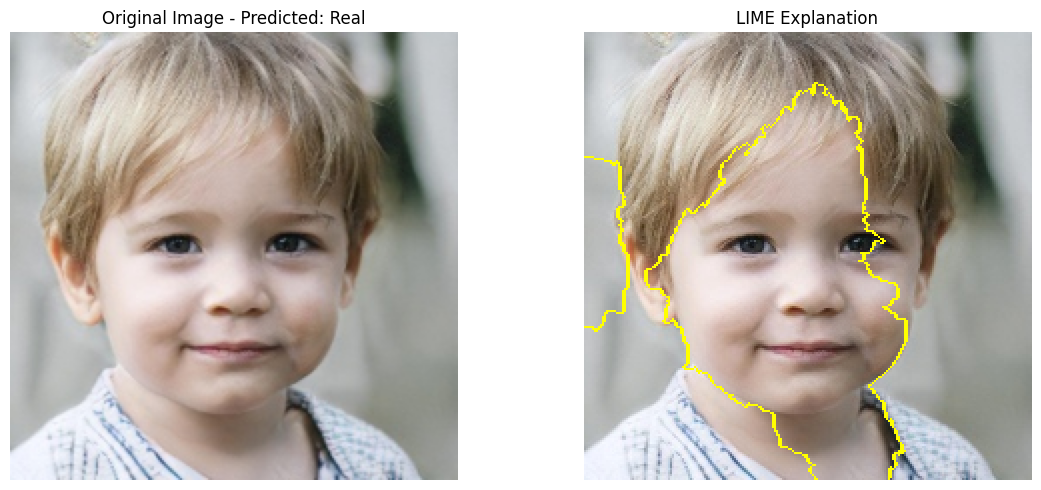


Integrated Gradients (IG) Visualization:
Prediction: Real with 94.50% confidence


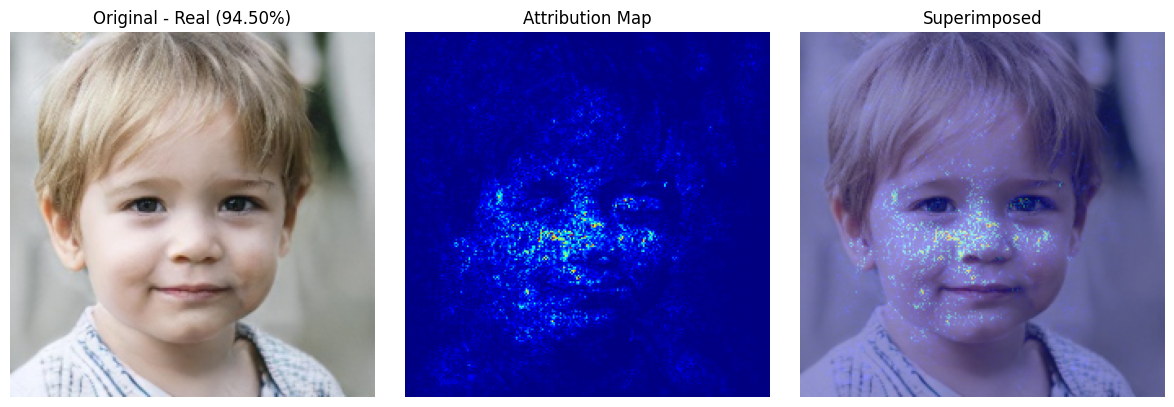


Predicting image /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/real/31671.jpg - Label: Fake

GradCAM Visualization:
Prediction: Fake
Probability of being fake: 0.9348

GradCAM Visualization:


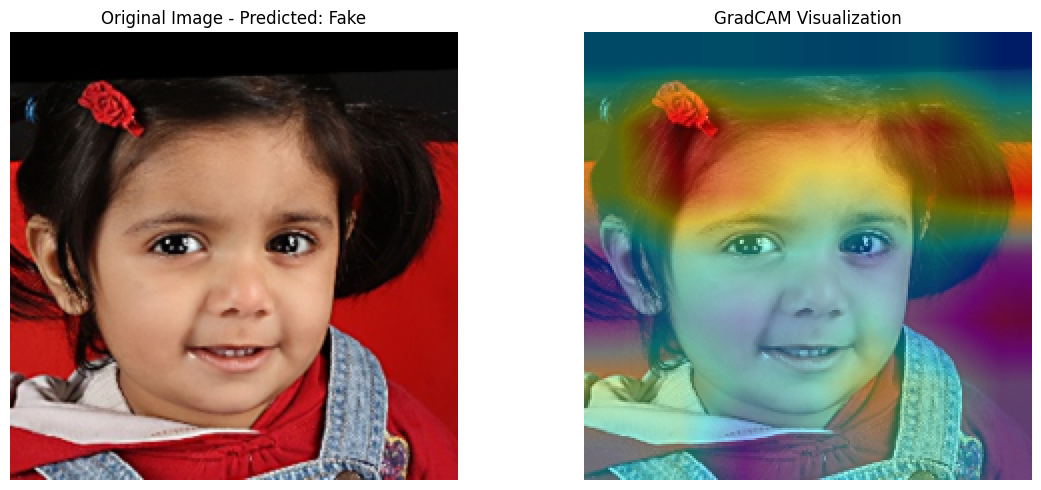


LIME Visualization:
Prediction: Fake
Probability of being fake: 0.9348

LIME Visualization:


  0%|          | 0/500 [00:00<?, ?it/s]

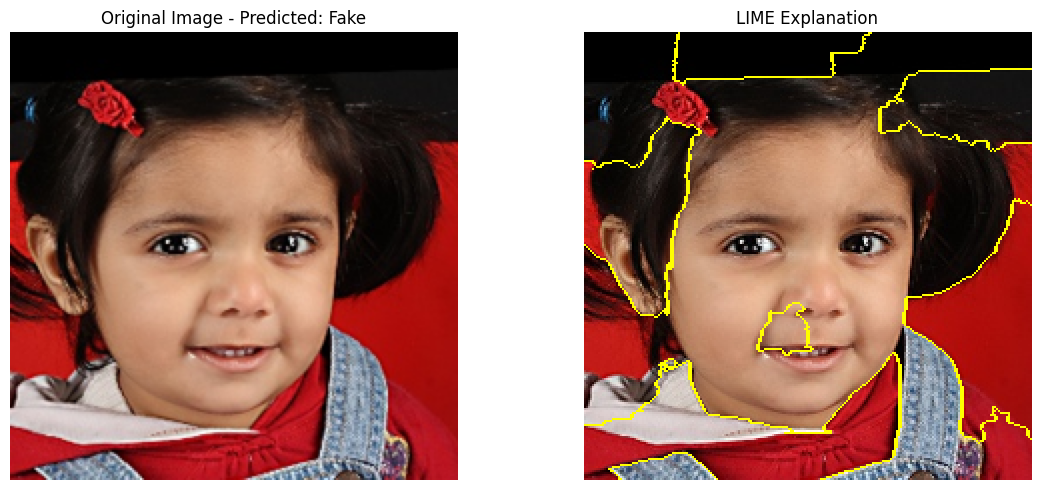


Integrated Gradients (IG) Visualization:
Prediction: Fake with 93.48% confidence


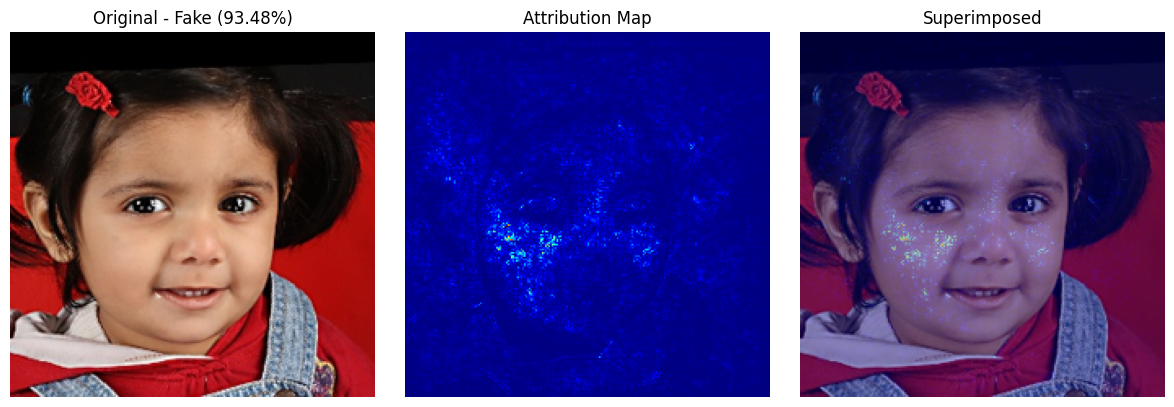


Predicting image /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/real/13010.jpg - Label: Fake

GradCAM Visualization:
Prediction: Fake
Probability of being fake: 0.9338

GradCAM Visualization:


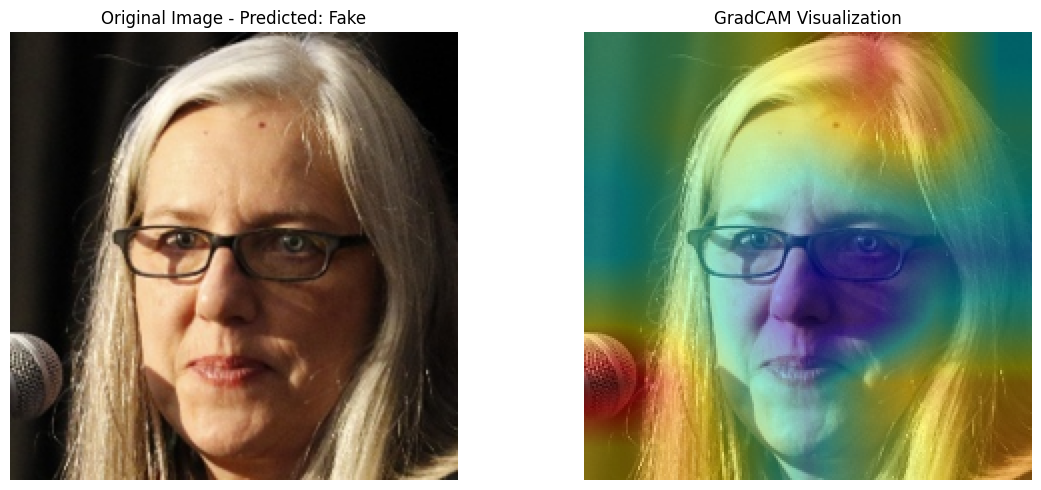


LIME Visualization:
Prediction: Fake
Probability of being fake: 0.9338

LIME Visualization:


  0%|          | 0/500 [00:00<?, ?it/s]

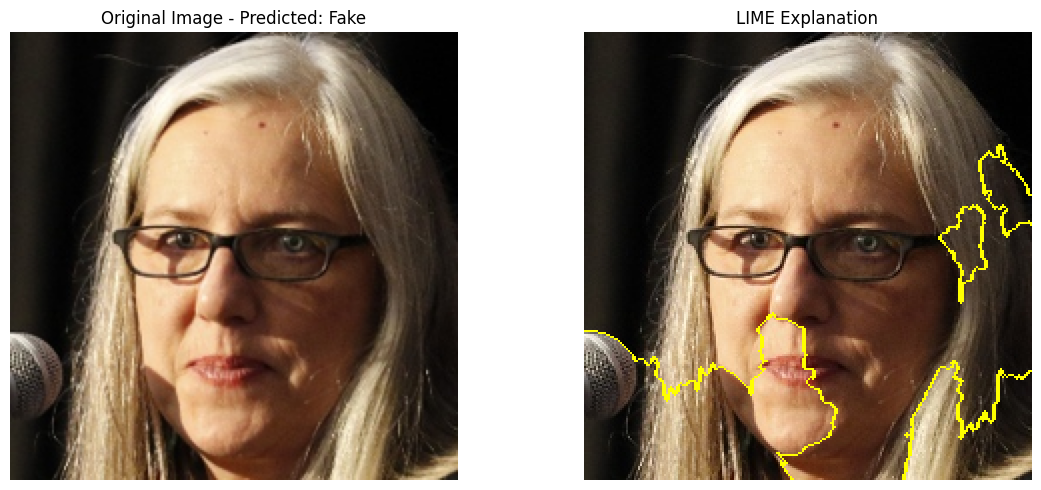


Integrated Gradients (IG) Visualization:
Prediction: Fake with 93.38% confidence


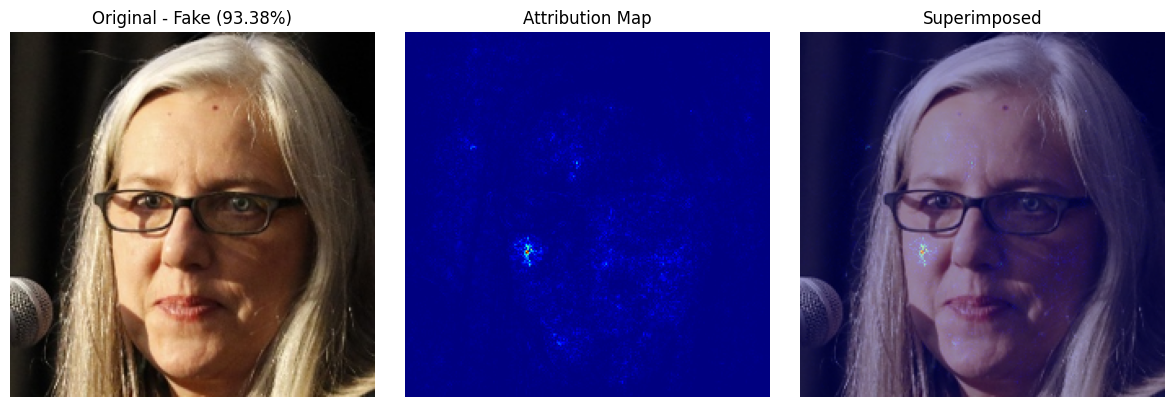


Predicting image /content/deepfake_dataset/real_vs_fake/real-vs-fake/test/real/03003.jpg - Label: Fake

GradCAM Visualization:
Prediction: Fake
Probability of being fake: 0.9340

GradCAM Visualization:


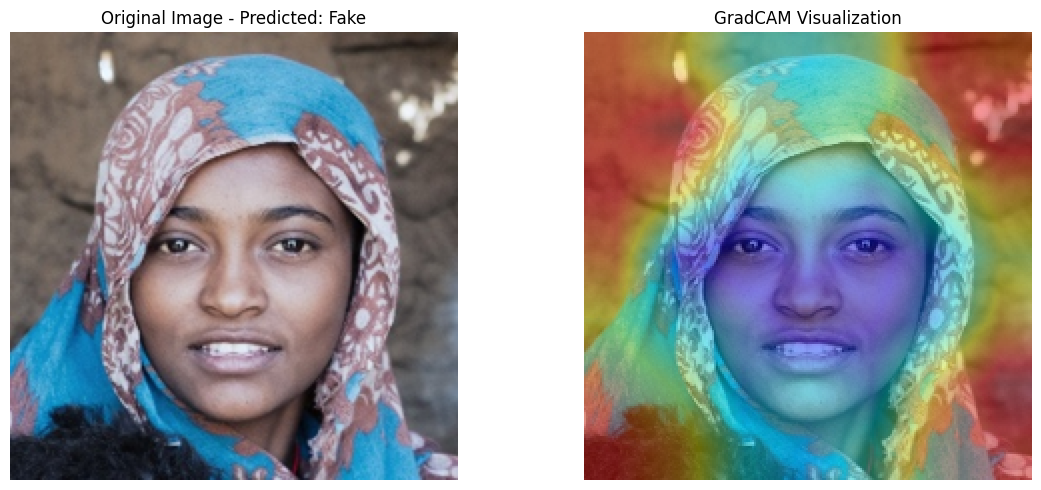


LIME Visualization:
Prediction: Fake
Probability of being fake: 0.9340

LIME Visualization:


  0%|          | 0/500 [00:00<?, ?it/s]

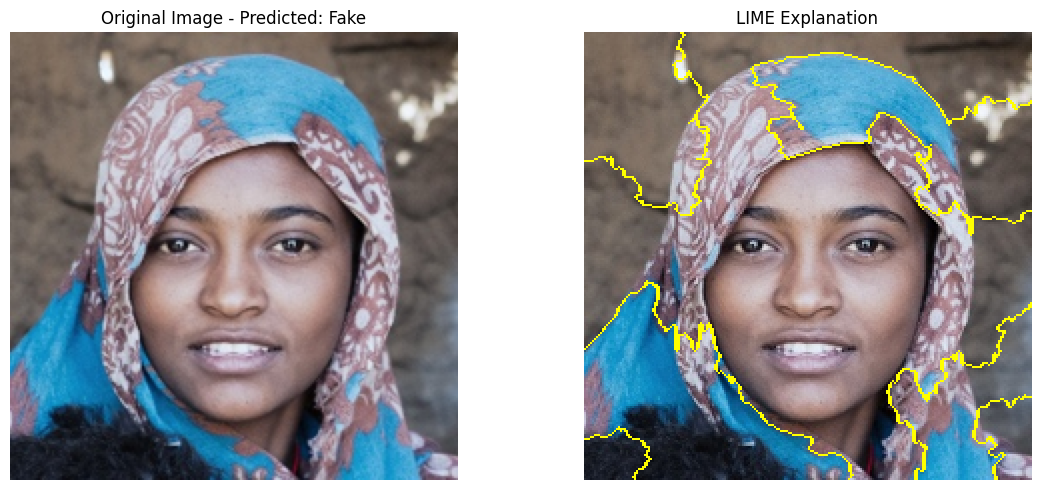


Integrated Gradients (IG) Visualization:
Prediction: Fake with 93.40% confidence


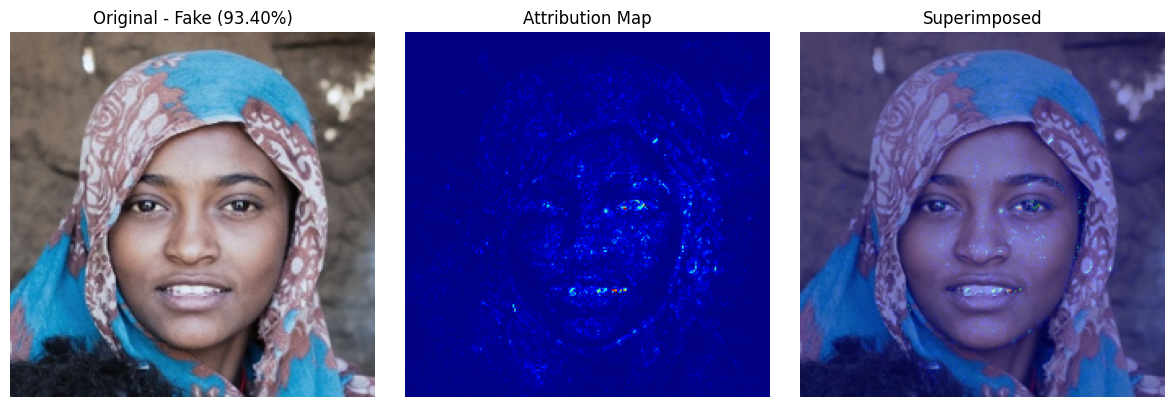

In [18]:
def upload_and_predict(model, test_dataset, device, xai_methods=['gradcam', 'lime', 'ig']):
    print("Selecting 5 random test samples (3 fake and 2 real) for prediction...")

    real_samples = [idx for idx, (_, label) in enumerate(test_dataset) if label == 0]  # Real label = 0
    fake_samples = [idx for idx, (_, label) in enumerate(test_dataset) if label == 1]  # Fake label = 1

    selected_fake_samples = random.sample(fake_samples, 3)
    selected_real_samples = random.sample(real_samples, 2)
    selected_samples = selected_fake_samples + selected_real_samples

    random.shuffle(selected_samples)

    for idx in selected_samples:

        image, label = test_dataset[idx]
        image_path = test_dataset.imgs[idx][0]

        print(f"\nPredicting image {image_path} - Label: {'Fake' if label == 1 else 'Real'}")

        image = image.to(device)

        if 'gradcam' in xai_methods:
            print("\nGradCAM Visualization:")
            pred_class, _ = predict_with_xai(model, image_path, xai_method='gradcam')

        if 'lime' in xai_methods:
            print("\nLIME Visualization:")
            predict_with_xai(model, image_path, xai_method='lime')

        if 'ig' in xai_methods:
            print("\nIntegrated Gradients (IG) Visualization:")
            pred_class, _ = apply_integrated_gradients(model, image.unsqueeze(0), Image.open(image_path).convert('RGB'))

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

test_dataset = datasets.ImageFolder(
    root='/content/deepfake_dataset/real_vs_fake/real-vs-fake/test',
    transform=data_transforms['val_test']
)

upload_and_predict(model, test_dataset, device)